In [31]:
import cv2
import numpy as np
from skimage import color
from matplotlib import pyplot as plt
from skimage import io, color, filters, util
import matplotlib.pyplot as plt


def removeBackground(image):

    #== Parameters =======================================================================
    BLUR = 21
    CANNY_THRESH_1 = 50
    CANNY_THRESH_2 = 200
    MASK_DILATE_ITER = 10
    MASK_ERODE_ITER = 10
    MASK_COLOR = (0.0,0.0,1.0) # In BGR format


    #== Processing =======================================================================

    #-- Read image -----------------------------------------------------------------------
    img = cv2.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)

    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    # _, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Previously, for a previous version of cv2, this line was: 
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Thanks to notes from commenters, I've updated the code but left this note
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]

    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))

    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending

    masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 

    # split image into channels
    c_red, c_green, c_blue = cv2.split(img)

    # merge with mask got on one of a previous steps
    img_a = cv2.merge((c_red, c_green, c_blue, mask.astype('float32') / 255.0))

    # show on screen (optional in jupiter)
    #%matplotlib inline
#     plt.imshow(img_a)
#     plt.show()

#     cv2.imshow('img', masked)                                   # Display
#     cv2.waitKey()

    #cv2.imwrite('C:/Temp/person-masked.jpg', masked)           # Save
#     i1 = masked
#     G = util.img_as_ubyte(color.rgb2gray(i1))
#     T = filters.threshold_otsu(G)
#     S = util.img_as_float(G > T)
    
    return masked

In [32]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import os

# create directories
dataset_home = 'Dataset/Motor/'
subdirs = ['Train/', 'Test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['bebek-nb/', 'offroad-nb/', 'Sport-nb/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)
        
        
# misahin gambar sama background
dataset_home = 'Dataset/Motor/'
subdirs = ['Train/', 'Test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['bebek/', 'offroad/', 'Sport/']
    for labldir in labeldirs:
        for i in listdir(dataset_home+subdir+labldir):
            if i.endswith(".jpg"):
                print(dataset_home + subdir + labldir + i)
                edited = removeBackground(dataset_home + subdir + labldir + i)
                if 'bebek' in labldir:
                    direct = 'bebek-nb/'
                    cv2.imwrite(os.path.join(dataset_home + subdir + direct, i), edited)
                elif 'offroad' in labldir:
                    direct = 'offroad-nb/'
                    cv2.imwrite(os.path.join(dataset_home + subdir + direct, i), edited)
                else:
                    direct = 'Sport-nb/'
                    cv2.imwrite(os.path.join(dataset_home + subdir + direct, i), edited)


Dataset/Motor/Train/bebek/bebek_9.jpg
Dataset/Motor/Train/bebek/bebek_8.jpg
Dataset/Motor/Train/bebek/bebek_1.jpg
Dataset/Motor/Train/bebek/bebek_9.jpg
Dataset/Motor/Train/bebek/bebek_8.jpg
Dataset/Motor/Train/bebek/bebek_1.jpg
Dataset/Motor/Train/bebek/bebek_9.jpg
Dataset/Motor/Train/bebek/bebek_8.jpg
Dataset/Motor/Train/bebek/bebek_1.jpg
Dataset/Motor/Train/bebek/bebek_3.jpg
Dataset/Motor/Train/bebek/bebek_2.jpg
Dataset/Motor/Train/bebek/bebek_6.jpg
Dataset/Motor/Train/bebek/bebek_5.jpg
Dataset/Motor/Train/bebek/bebek_4.jpg
Dataset/Motor/Train/bebek/bebek_3.jpg
Dataset/Motor/Train/bebek/bebek_2.jpg
Dataset/Motor/Train/bebek/bebek_6.jpg
Dataset/Motor/Train/bebek/bebek_5.jpg
Dataset/Motor/Train/bebek/bebek_4.jpg
Dataset/Motor/Train/bebek/bebek_3.jpg
Dataset/Motor/Train/bebek/bebek_2.jpg
Dataset/Motor/Train/bebek/bebek_6.jpg
Dataset/Motor/Train/bebek/bebek_5.jpg
Dataset/Motor/Train/bebek/bebek_4.jpg
Dataset/Motor/Train/bebek/bebek_10.jpg
Dataset/Motor/Train/bebek/bebek_13.jpg
Dataset/Mo

/Users/irfanamrullah/Documents/Kuliah/Pengolahan_Citra/Lab/venv/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


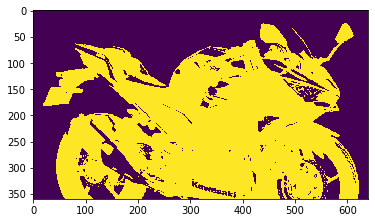

/Users/irfanamrullah/Documents/Kuliah/Pengolahan_Citra/Lab/venv/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/irfanamrullah/Documents/Kuliah/Pengolahan_Citra/Lab/venv/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


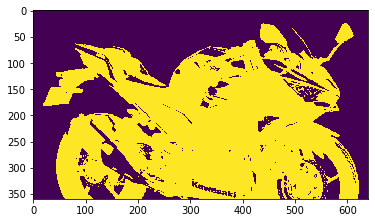

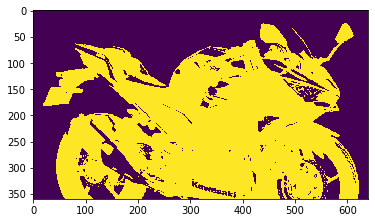

/Users/irfanamrullah/Documents/Kuliah/Pengolahan_Citra/Lab/venv/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Users/irfanamrullah/Documents/Kuliah/Pengolahan_Citra/Lab/venv/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Use

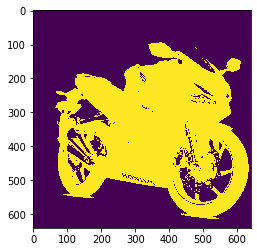

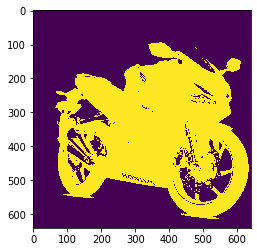

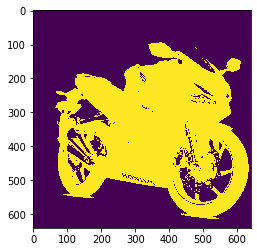

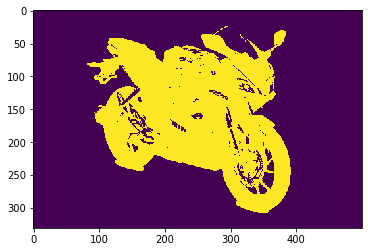

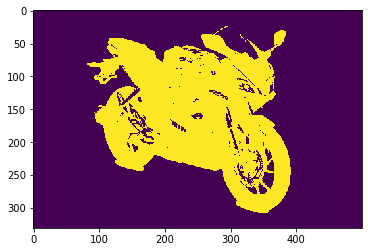

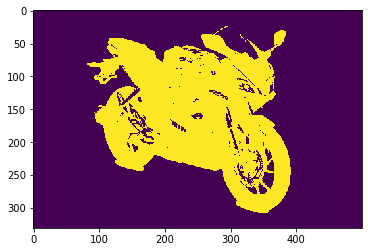

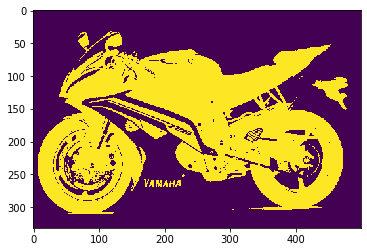

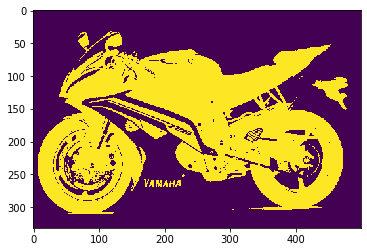

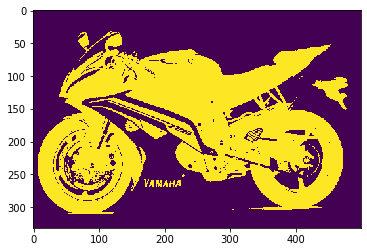

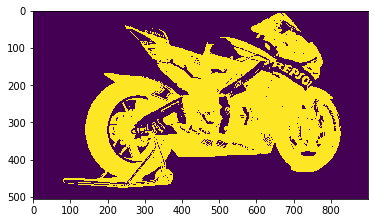

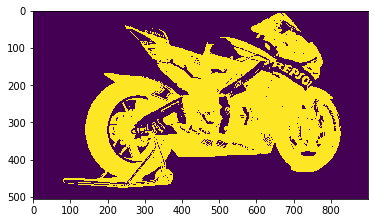

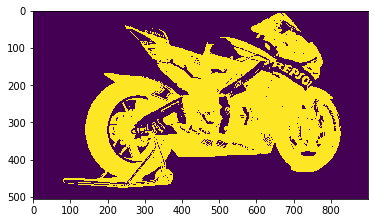

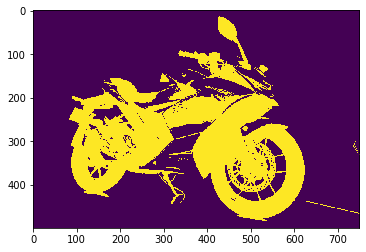

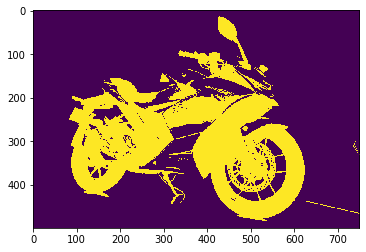

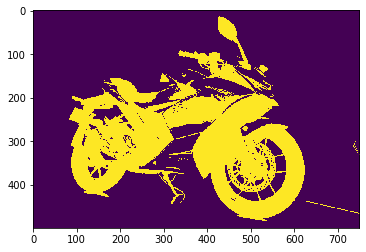

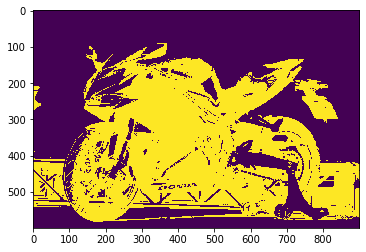

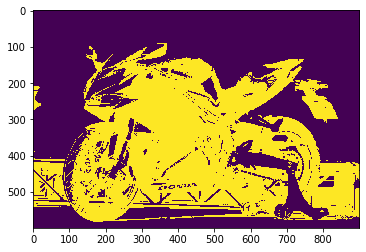

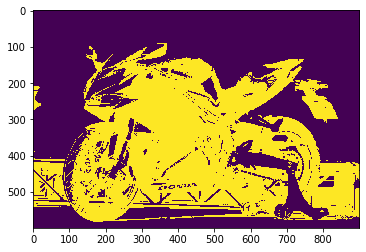

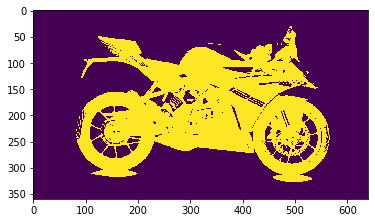

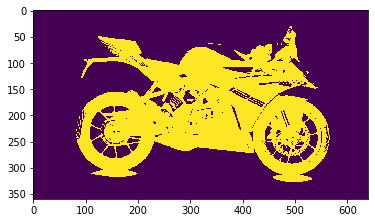

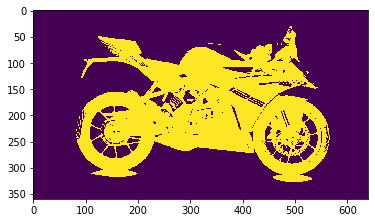

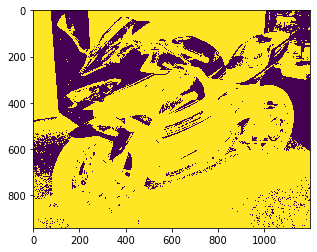

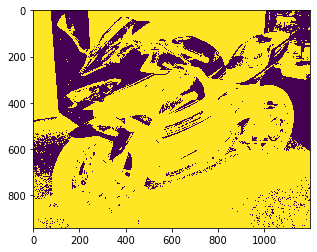

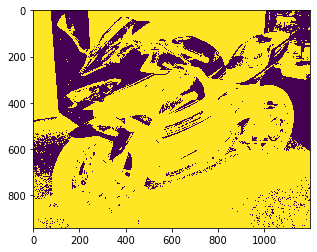

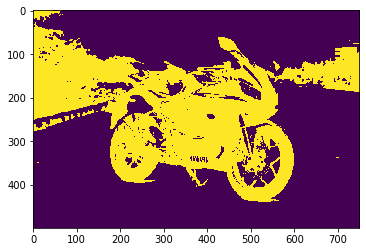

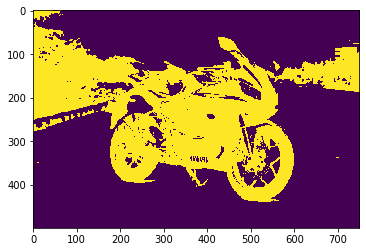

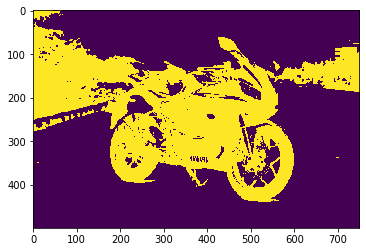

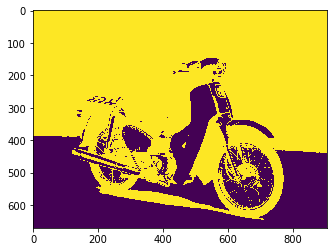

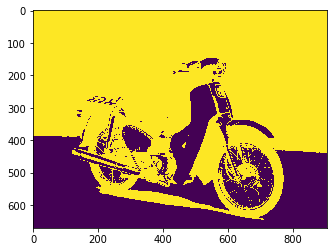

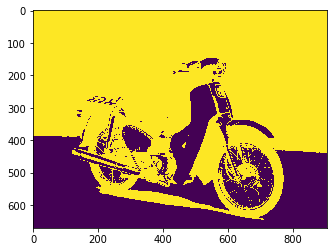

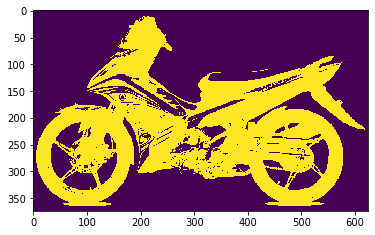

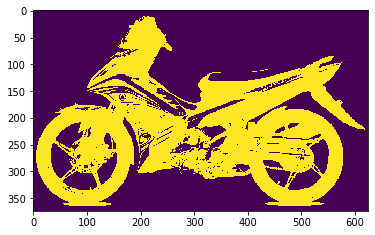

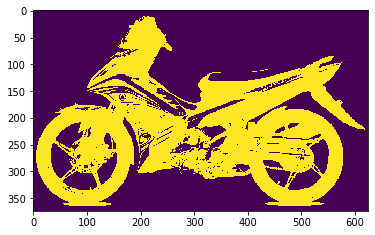

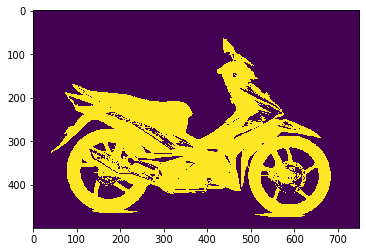

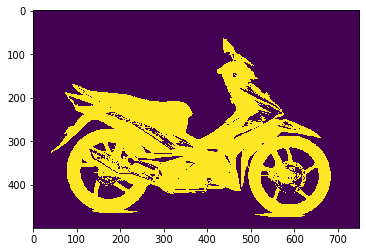

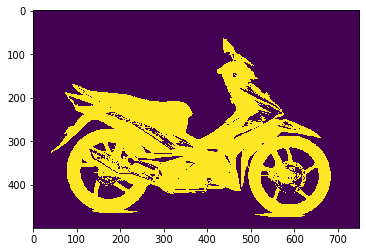

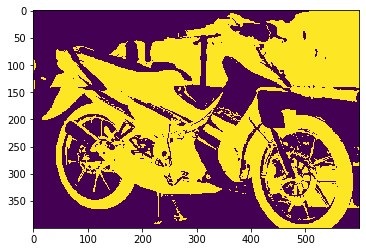

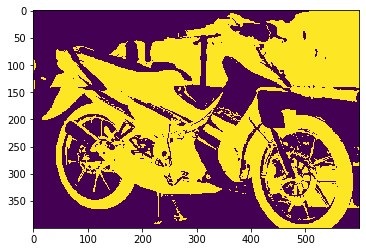

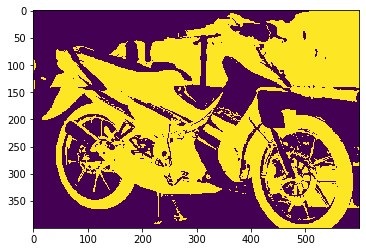

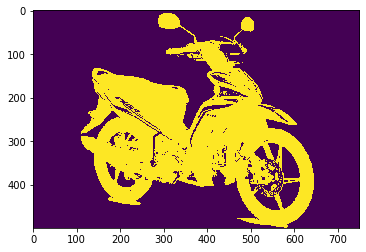

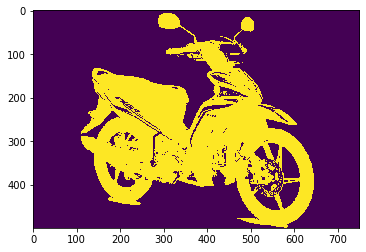

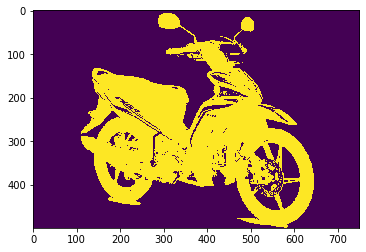

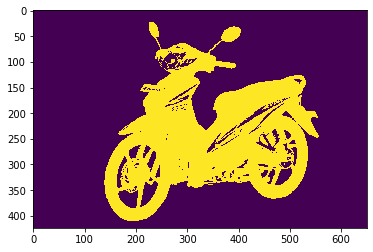

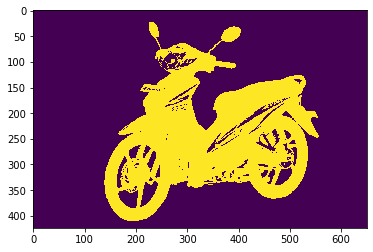

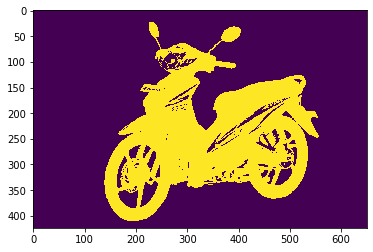

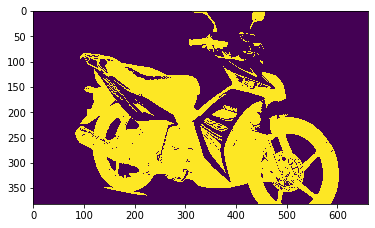

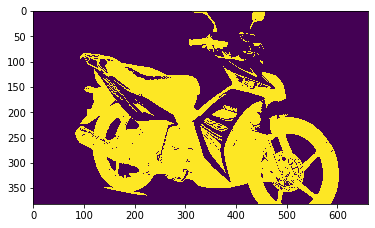

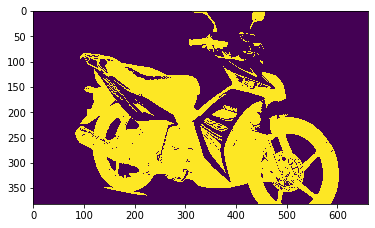

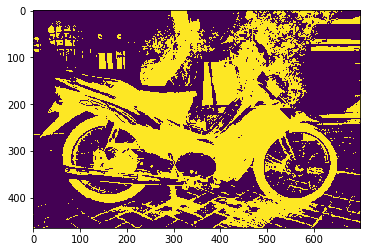

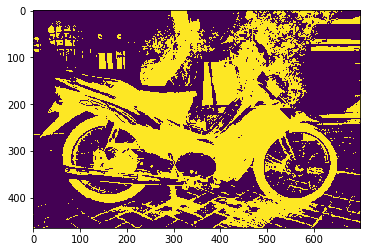

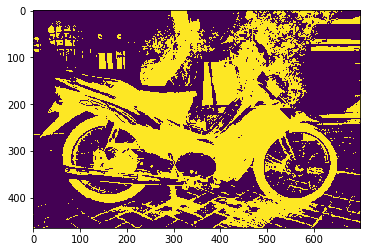

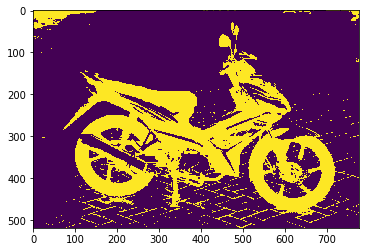

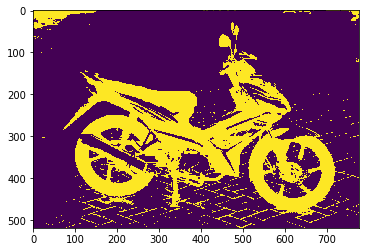

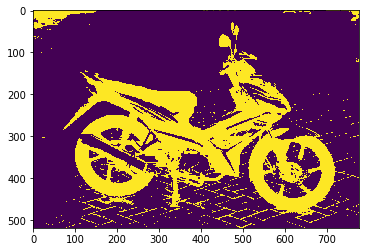

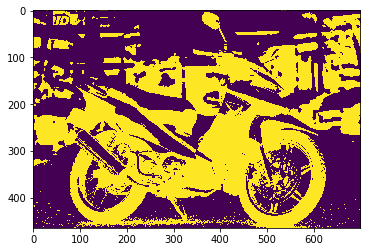

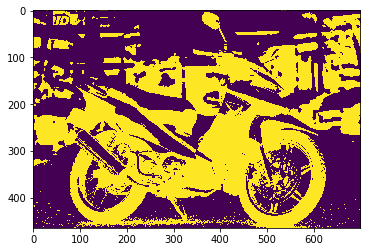

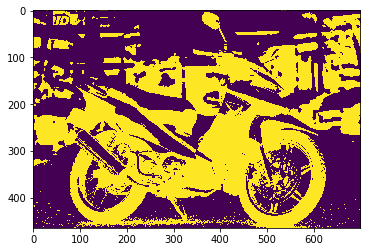

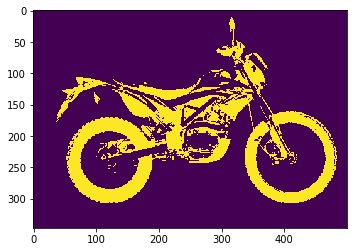

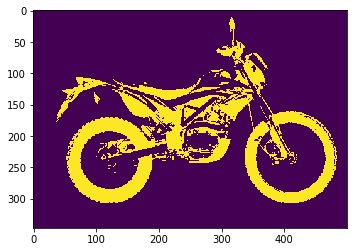

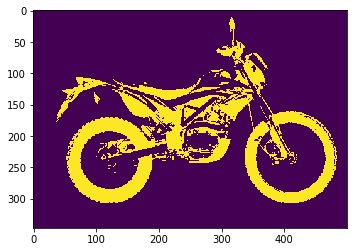

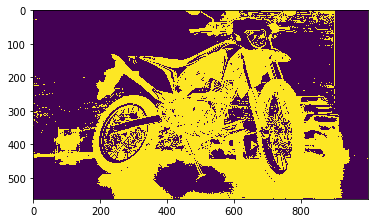

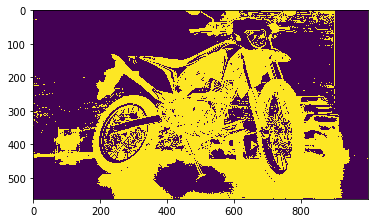

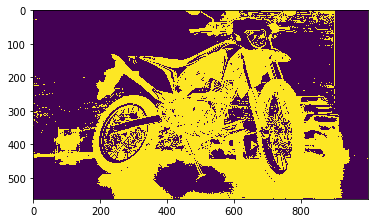

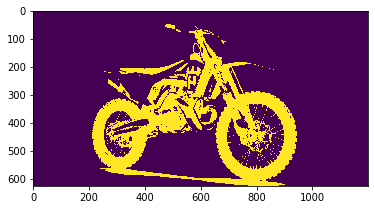

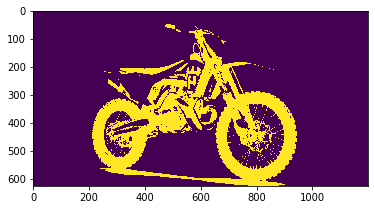

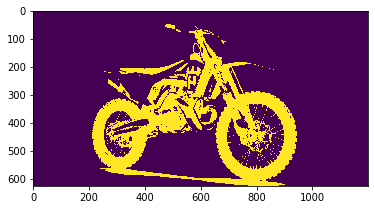

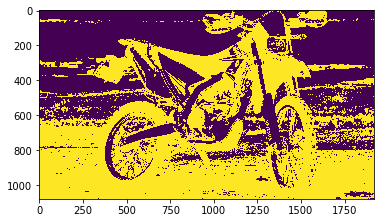

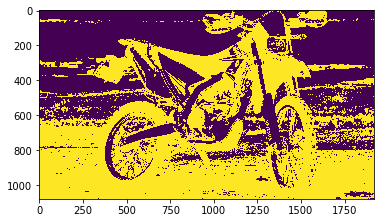

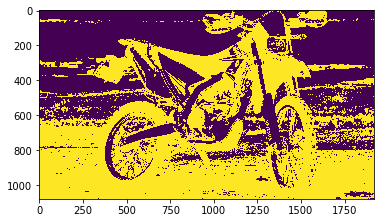

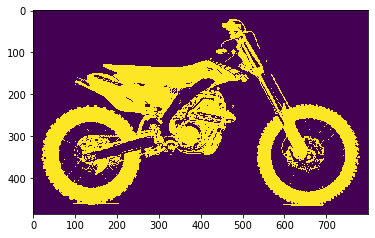

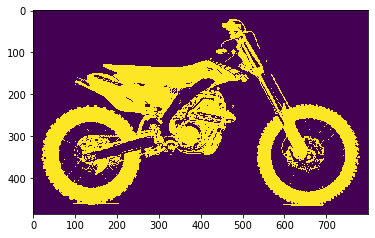

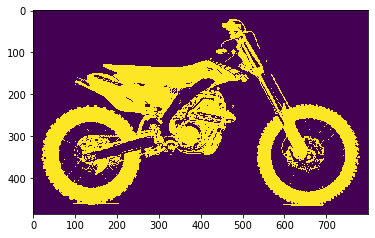

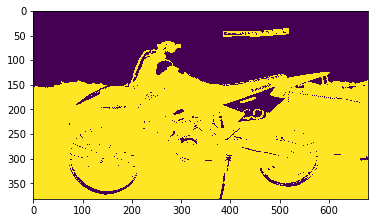

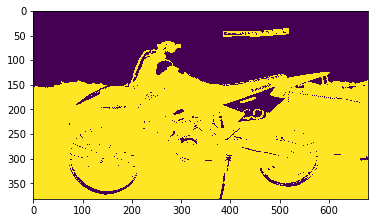

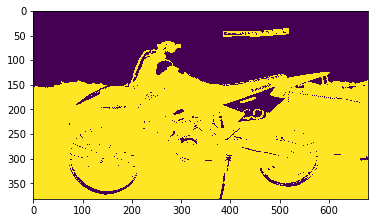

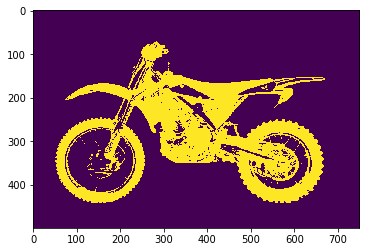

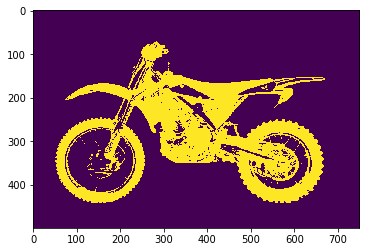

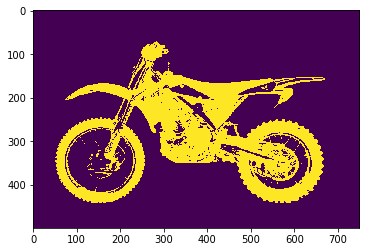

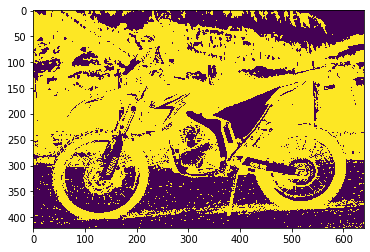

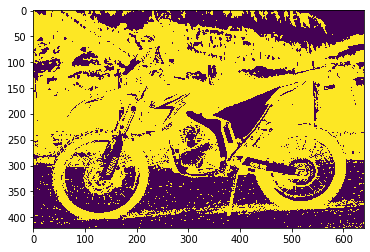

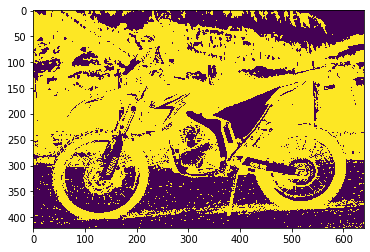

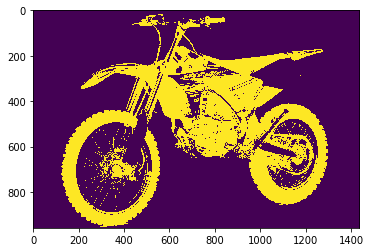

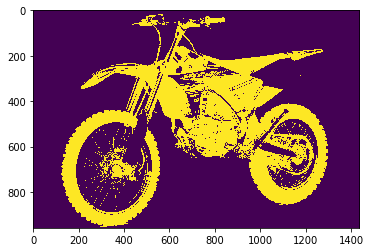

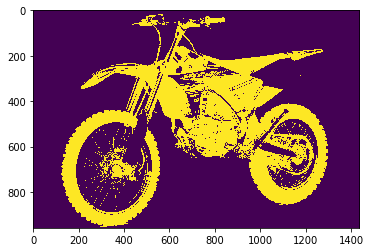

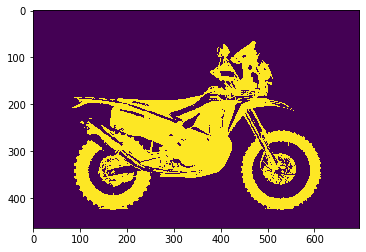

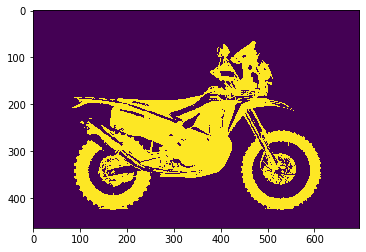

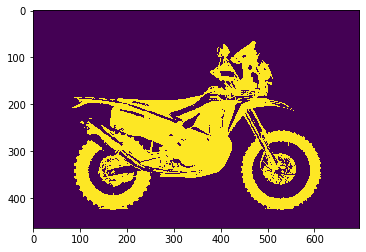

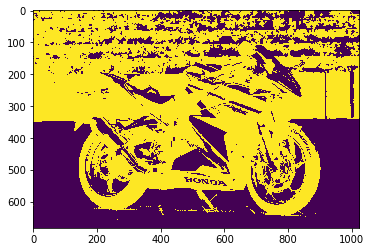

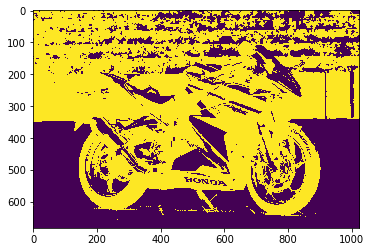

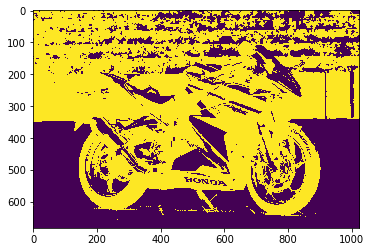

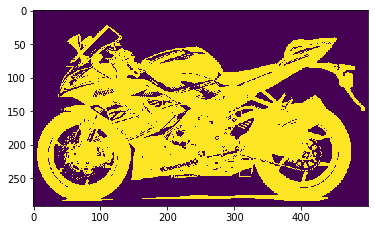

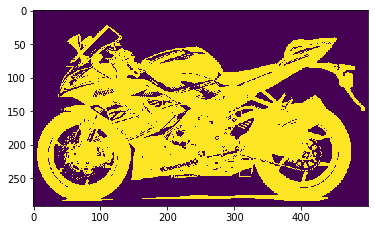

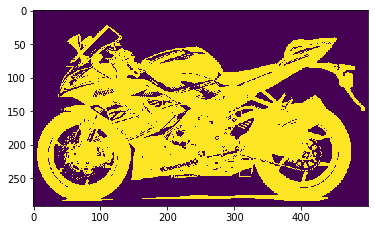

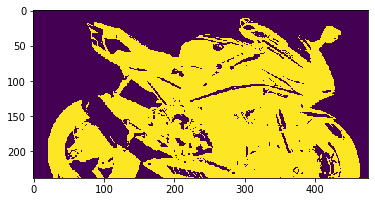

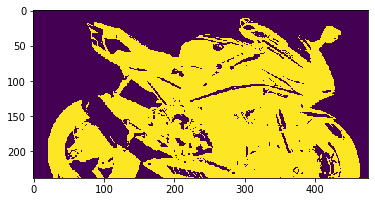

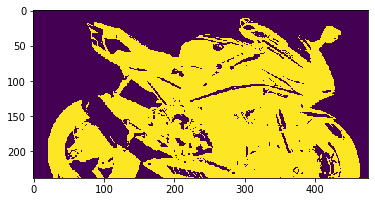

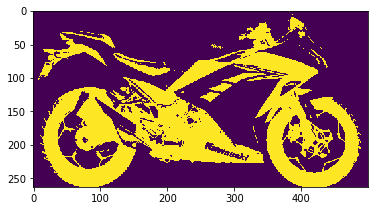

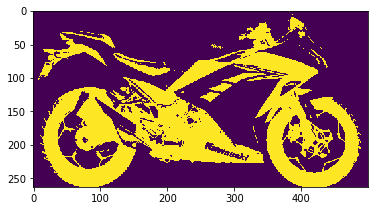

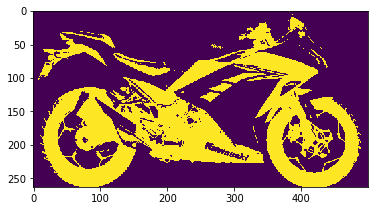

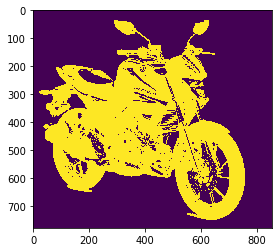

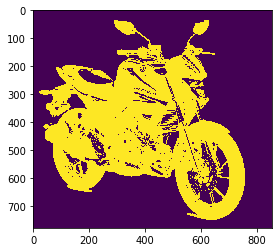

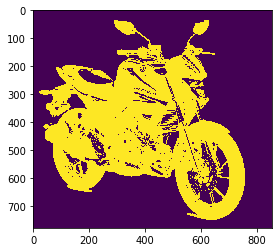

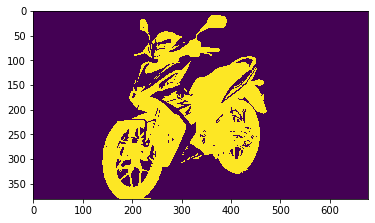

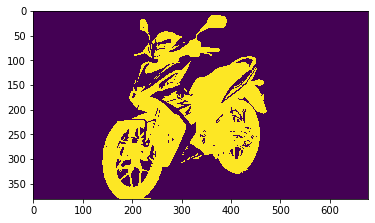

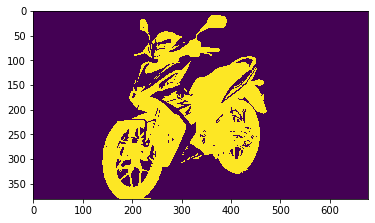

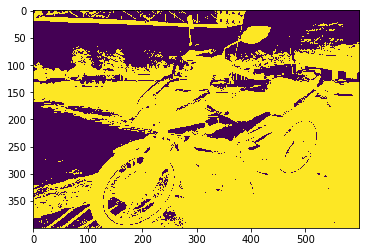

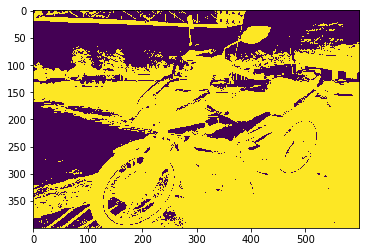

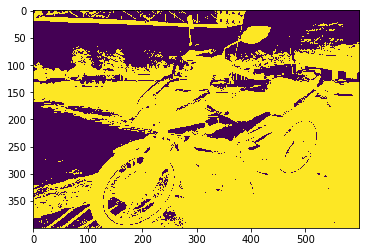

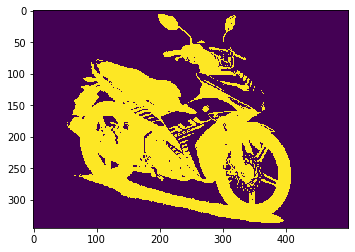

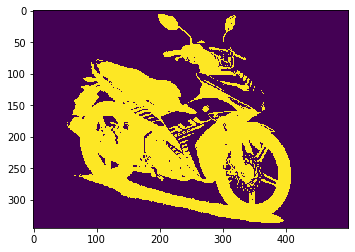

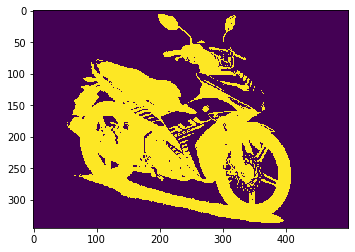

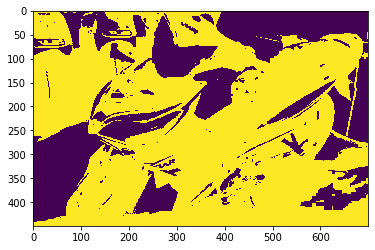

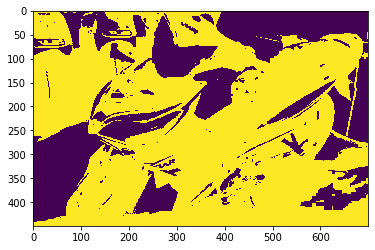

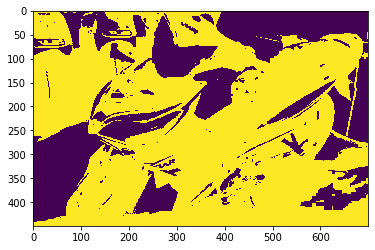

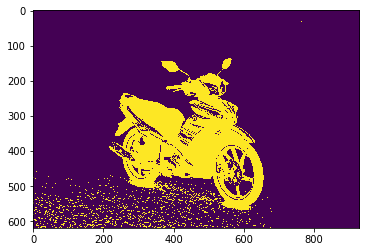

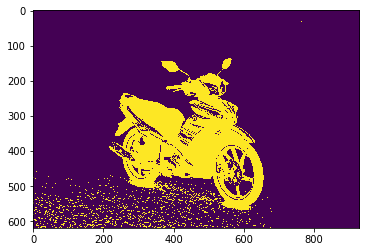

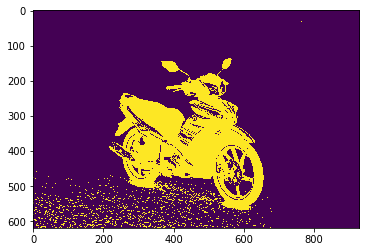

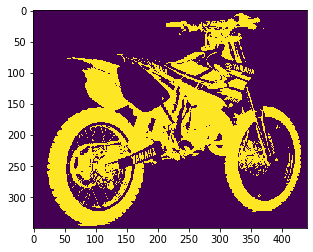

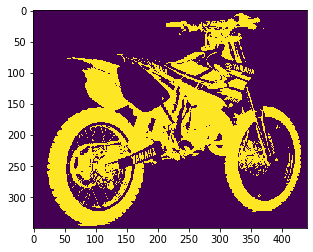

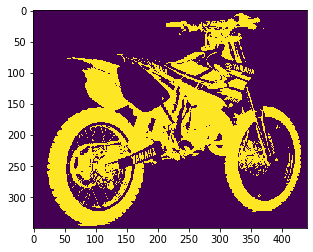

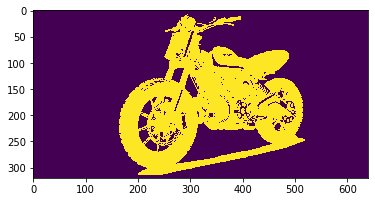

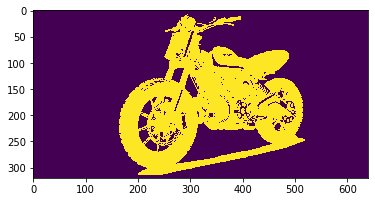

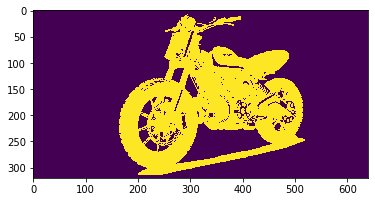

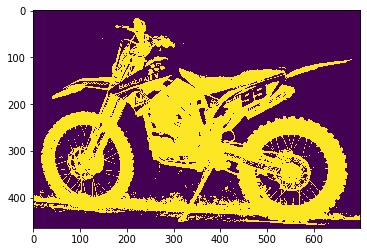

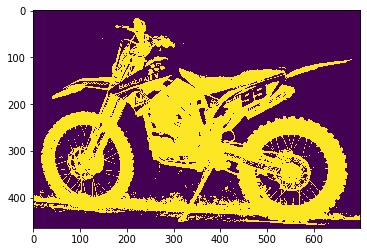

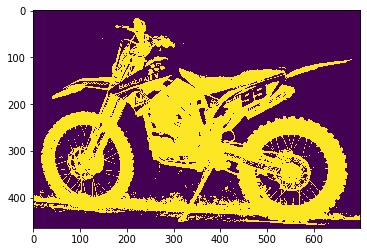

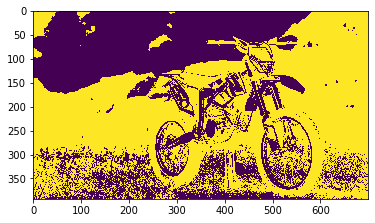

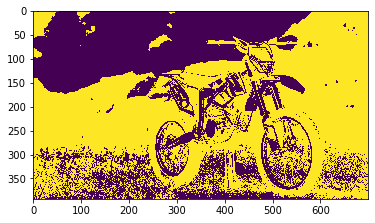

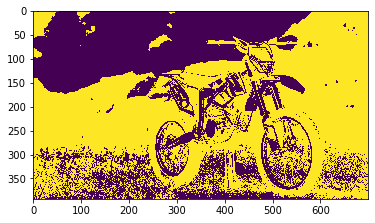

In [89]:
from skimage import measure, io, img_as_bool
import numpy as np
import glob
from cv2 import Sobel

files = glob.glob("Dataset/Motor/Train/*-i/*.jpg")
train_shape_feature = np.zeros((30,7))
for k in range(len(files)):
    BW1 = io.imread(files[k])
    G = util.img_as_ubyte(color.rgb2gray(BW1))
    T = filters.threshold_otsu(G)
    S = util.img_as_float(G < T)
#     img = np.float32(BW1) / 255.0 
#     gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
#     gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
#     mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    plt.imshow(S)
    plt.show()
    sf = measure.regionprops(S.astype(int))
    shape_feature = [max(s.equivalent_diameter for s in sf),
    max(s.perimeter for s in sf),
    max(s.area for s in sf),
    max(s.filled_area for s in sf),
    max(s.convex_area for s in sf),
    max(s.eccentricity for s in sf),
    max(s.orientation for s in sf),]
    train_shape_feature[k,:] = shape_feature
np.savetxt('train_shape_feature.csv', train_shape_feature, delimiter=',', fmt='%f')

files = glob.glob("Dataset/Motor/Test/*-i/*.jpg")
test_shape_feature = np.zeros((14,7))
for k in range(len(files)):
    BW1 = io.imread(files[k])
    G = util.img_as_ubyte(color.rgb2gray(BW1))
    T = filters.threshold_otsu(G)
    S = util.img_as_float(G < T)
#     img = np.float32(BW1) / 255.0 
#     gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
#     gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
#     mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    plt.imshow(S)
    plt.show()
    sf = measure.regionprops(S.astype(int))
    shape_feature = [max(s.equivalent_diameter for s in sf),
    max(s.perimeter for s in sf),
    max(s.area for s in sf),
    max(s.filled_area for s in sf),
    max(s.convex_area for s in sf),
    max(s.eccentricity for s in sf),
    max(s.orientation for s in sf)]
    test_shape_feature[k,:] = shape_feature
np.savetxt('test_shape_feature.csv', test_shape_feature, delimiter=',', fmt='%f')

In [90]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(3)
clf.fit(train_shape_feature, train_label)
svm_label = clf.predict(test_shape_feature)
cm_svm = metrics.confusion_matrix(svm_label, test_label)
print(cm_svm)

eval_svm = evaluate(test_label,svm_label)
accuracy = eval_svm[0]*100
sensitivity = eval_svm[1]*100
specificity = eval_svm[2]*100
precision = eval_svm[3]*100
recall = eval_svm[4]*100
f_measure = eval_svm[5]*100
print("Akurasi: %f" % (accuracy))
print("Sensitivity: %f" % (sensitivity))
print("Specificity: %f" % (specificity))
print("Precision: %f" % (precision))
print("Recall: %f" % (recall))
print("f_measure: %f" % (f_measure))

clf = neighbors.KNeighborsClassifier(7)
clf.fit(train_shape_feature, train_label)
svm_label = clf.predict(test_shape_feature)
cm_svm = metrics.confusion_matrix(svm_label, test_label)
print(cm_svm)

eval_svm = evaluate(test_label,svm_label)
accuracy = eval_svm[0]*100
sensitivity = eval_svm[1]*100
specificity = eval_svm[2]*100
precision = eval_svm[3]*100
recall = eval_svm[4]*100
f_measure = eval_svm[5]*100
print("Akurasi: %f" % (accuracy))
print("Sensitivity: %f" % (sensitivity))
print("Specificity: %f" % (specificity))
print("Precision: %f" % (precision))
print("Recall: %f" % (recall))
print("f_measure: %f" % (f_measure))



[[5 3]
 [2 4]]
Akurasi: 64.285714
Sensitivity: 71.428571
Specificity: 57.142857
Precision: 62.500000
Recall: 71.428571
f_measure: 66.666667
[[1 0]
 [6 7]]
Akurasi: 57.142857
Sensitivity: 14.285714
Specificity: 100.000000
Precision: 100.000000
Recall: 14.285714
f_measure: 25.000000


/Users/irfanamrullah/Documents/Kuliah/Pengolahan_Citra/Lab/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/irfanamrullah/Documents/Kuliah/Pengolahan_Citra/Lab/venv/lib/python3.7/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[[5 3]
 [2 4]]
Akurasi: 64.285714
Sensitivity: 71.428571
Specificity: 57.142857
Precision: 62.500000
Recall: 71.428571
f_measure: 66.666667
[[1 0]
 [6 7]]
Akurasi: 57.142857
Sensitivity: 14.285714
Specificity: 100.000000
Precision: 100.000000
Recall: 14.285714
f_measure: 25.000000
[[5 3]
 [2 4]]
Akurasi: 64.285714
Sensitivity: 71.428571
Specificity: 57.142857
Precision: 62.500000
Recall: 71.428571
f_measure: 66.666667
[[1 0]
 [6 7]]
Akurasi: 57.142857
Sensitivity: 14.285714
Specificity: 100.000000
Precision: 100.000000
Recall: 14.285714
f_measure: 25.000000


/Users/irfanamrullah/Documents/Kuliah/Pengolahan_Citra/Lab/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/irfanamrullah/Documents/Kuliah/Pengolahan_Citra/Lab/venv/lib/python3.7/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/irfanamrullah/Documents/Kuliah/Pengolahan_Citra/Lab/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/irfanamru